WARNING    'v' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value array([0.        , 0.        , 0.        , ..., 0.00765394, 0.00757778,
       0.00750238], shape=(1100,)). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Feature matrix: (40, 5) Target shape: (40,)
Saved features/labels to ../data/
Class distribution: {0: 16, 1: 12, 2: 12}
[Regression] MAE=0.0483, R^2=0.9578

[Regression] Feature importances (permutation):
  peak_v: 1.6435 +/- 0.5901
  area_v: 0.0279 +/- 0.0149
  spectral_centroid: 0.0198 +/- 0.0127
  t_peak: 0.0008 +/- 0.0010
  decay_tau: -0.0001 +/- 0.0019
Saved regressor → ../models/agg_index_regressor.joblib

[Classification] Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         4
           1      1.000     1.000     1.000         3
           2      1.000     1.000     1.000         3

    accuracy                          1.000        10
   macro avg      1.000     1.000     1.000        10
weighted avg      1.000     1.000     1.000        10

Confusion matrix:
 [[4 0 0]
 [0 3 0]
 [0 0 3]]


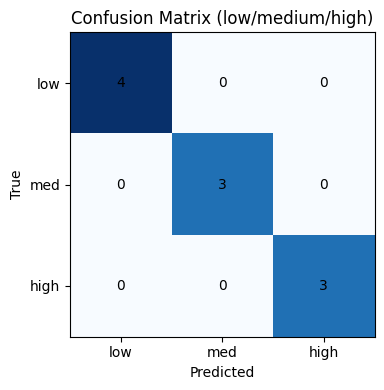

Saved classifier → ../models/agg_severity_classifier.joblib

[Inference demo] True A=0.55 → Predicted A=0.52, class=medium
Features: {'peak_v': np.float64(0.2970129881242649), 'area_v': np.float64(6.962537640470703), 't_peak': np.float64(20.099999999999998), 'decay_tau': np.float64(21.101219456312304), 'spectral_centroid': np.float64(21.268844490252217)}


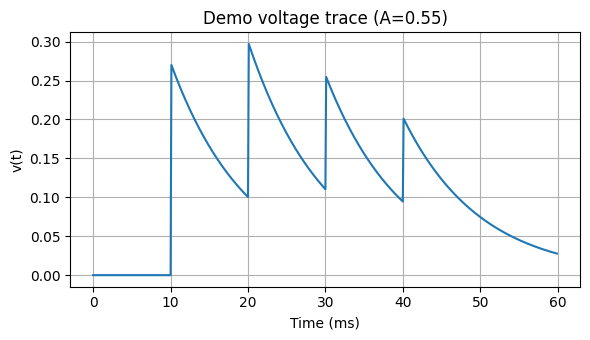

In [11]:
# 05_ml_analysis.ipynb (single-cell)
# Machine Learning on synaptic signal degradation patterns (alpha-synuclein aggregation)


from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import joblib

# -----------------------------
# Setup
# -----------------------------
# Inline plotting for Jupyter
%matplotlib inline

# Folders
os.makedirs('../figures', exist_ok=True)
os.makedirs('../data', exist_ok=True)
os.makedirs('../models', exist_ok=True)

# Deterministic run and smooth integration for clock-driven dynamics
np.random.seed(42)
defaultclock.dt = 0.1*ms

# Optional: silence Brian2 "internal variable will be used" warnings (best fix is variable renaming below)
warnings.filterwarnings(
    "ignore",
    message=".*internal variable of group 'neurongroup_.*' .* also exists in the run namespace.*"
)

# -----------------------------
# Simulation helper (matches 03_* mapping)
# -----------------------------
def run_trial(A, spike_times, tau=10*ms):
    """
    Run one Brian2 trial at fixed aggregation A and return (t_ms, v_trace).
    Mirrors your 03_* mapping:
      Pr_effect      = 0.6 * (1 - A)
      tau_rec_effect = 800*ms * (1 + A)
      Synapse: v_post += Pr_effect * x ; x -= Pr_effect * x
      dx/dt  : (1 - x) / tau_rec_effect  (clock-driven)
    """
    start_scope()

    # Biological mapping
    Pr_effect      = 0.6 * (1 - A)
    tau_rec_effect = 800*ms * (1 + A)

    # Presynaptic spikes
    source = SpikeGeneratorGroup(1, indices=[0]*len(spike_times), times=spike_times)

    # Postsynaptic neuron (subthreshold LIF)
    post = NeuronGroup(1, 'dv/dt = -v/tau : 1', method='exact')

    # Synapse with short-term depression (explicit method='exact')
    S = Synapses(
        source, post,
        '''
        dx/dt = (1 - x)/tau_rec_effect : 1 (clock-driven)
        ''',
        on_pre='''
        v_post += Pr_effect * x
        x -= Pr_effect * x
        ''',
        method='exact'
    )
    S.connect()
    S.x = 1.0

    # Record voltage
    M = StateMonitor(post, 'v', record=True)

    # Simulate
    run((max(spike_times) + 20*ms))

    # Return time (ms) and voltage array
    t_ms    = np.array(M.t/ms, dtype=float)
    v_trace = np.array(M.v[0], dtype=float)
    return t_ms, v_trace

# -----------------------------
# Feature engineering (robust & lightweight)
# -----------------------------
def compute_features(t_ms, v_trace):
    """
    Features from a voltage trace:
      - peak_v           : max(v)
      - area_v           : integral over time (ms) via np.trapezoid
      - t_peak           : time to peak (ms)
      - decay_tau        : exponential decay constant (ms) after peak (log-linear fit)
      - spectral_centroid: FFT-based frequency centroid (Hz)
    """
    v0 = v_trace - np.min(v_trace)  # baseline subtract

    peak_v = float(np.max(v0))
    area_v = float(np.trapezoid(v0, t_ms))  # np.trapz → np.trapezoid

    t_peak_idx = int(np.argmax(v0))
    t_peak     = float(t_ms[t_peak_idx])

    # Decay tau via log-linear fit on the tail
    tail_mask = t_ms >= t_peak
    t_tail = t_ms[tail_mask]
    v_tail = v0[tail_mask]
    eps = 1e-9
    if len(t_tail) >= 5 and np.all(np.isfinite(v_tail)):
        y = np.log(v_tail + eps)
        coef = np.polyfit(t_tail - t_tail[0], y - y[0], 1)  # slope in 1/ms
        decay_tau = float(-1.0 / coef[0]) if coef[0] < 0 else np.inf
    else:
        decay_tau = np.nan

    # Spectral centroid
    if len(t_ms) > 1:
        dt_sec = (t_ms[1] - t_ms[0]) / 1000.0
        freqs = np.fft.rfftfreq(len(t_ms), d=dt_sec)
        Vfft = np.fft.rfft(v0)
        P = np.abs(Vfft)**2
        spectral_centroid = float(np.sum(freqs * P) / np.sum(P)) if np.sum(P) > 0 else 0.0
    else:
        spectral_centroid = 0.0

    return np.array([peak_v, area_v, t_peak, decay_tau, spectral_centroid], dtype=float)

feature_names = np.array(['peak_v', 'area_v', 't_peak', 'decay_tau', 'spectral_centroid'], dtype='<U32')

# -----------------------------
# Build a compact dataset (no changes to 03_*)
# -----------------------------
A_grid = np.linspace(0.0, 0.9, 10)  # up to 0.9 to avoid strict zeros at 1.0
protocols = [
    np.array([10, 20])*ms,                  # same as 03_* (two spikes)
    np.array([10, 20, 30, 40])*ms,          # four spikes
    np.array([10, 15, 20, 25, 30, 35])*ms,  # faster train (5 ms steps)
    np.array([10, 50, 90])*ms               # sparse spikes
]

X_list, yA_list = [], []
for A in A_grid:
    for spike_times in protocols:
        t_ms, v_trace = run_trial(A, spike_times)
        X_list.append(compute_features(t_ms, v_trace))
        yA_list.append(float(A))

X = np.vstack(X_list).astype(float)
y_reg = np.array(yA_list, dtype=float)

print('Feature matrix:', X.shape, 'Target shape:', y_reg.shape)
np.save('../data/features.npy', X)
np.save('../data/labels_regression.npy', y_reg)
np.save('../data/feature_names.npy', feature_names)
print('Saved features/labels to ../data/')

# -----------------------------
# Classification target (bins)
# -----------------------------
y_cls = np.digitize(y_reg, bins=[0.33, 0.66])  # 0=low, 1=medium, 2=high
classes, counts = np.unique(y_cls, return_counts=True)
print('Class distribution:', {int(c): int(n) for c, n in zip(classes, counts)})

# -----------------------------
# Train/test splits
# -----------------------------
X_train, X_test, yreg_train, yreg_test = train_test_split(
    X, y_reg, test_size=0.25, random_state=42
)
Xc_train, Xc_test, ycls_train, ycls_test = train_test_split(
    X, y_cls, test_size=0.25, random_state=42, stratify=y_cls
)

# -----------------------------
# Regressor: predict aggregation index (A)
# -----------------------------
reg = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=400, random_state=42))
])
reg.fit(X_train, yreg_train)
ypred = reg.predict(X_test)

mae = mean_absolute_error(yreg_test, ypred)
r2  = r2_score(yreg_test, ypred)
print(f'[Regression] MAE={mae:.4f}, R^2={r2:.4f}')

# Permutation importance (ASCII +/- to avoid unicode issues)
imp = permutation_importance(reg, X_test, yreg_test, n_repeats=10, random_state=42)
order = np.argsort(-imp.importances_mean)
print("\n[Regression] Feature importances (permutation):")
for idx in order:
    mean = float(imp.importances_mean[idx])
    std  = float(imp.importances_std[idx])
    name = str(feature_names[idx])
    print(f"  {name}: {mean:.4f} +/- {std:.4f}")

joblib.dump(reg, '../models/agg_index_regressor.joblib')
print('Saved regressor → ../models/agg_index_regressor.joblib')

# -----------------------------
# Classifier: severity (low/medium/high)
# -----------------------------
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42))
])
clf.fit(Xc_train, ycls_train)
ycls_pred = clf.predict(Xc_test)

print('\n[Classification] Report:')
print(classification_report(ycls_test, ycls_pred, digits=3))

cm = confusion_matrix(ycls_test, ycls_pred)
print('Confusion matrix:\n', cm)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix (low/medium/high)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks([0,1,2], ['low','med','high']); plt.yticks([0,1,2], ['low','med','high'])
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.savefig('../figures/05_cls_confusion.png', dpi=150)
plt.show()

joblib.dump(clf, '../models/agg_severity_classifier.joblib')
print('Saved classifier → ../models/agg_severity_classifier.joblib')

# -----------------------------
# Inference helper (single trace)
# -----------------------------
def predict_from_trace(t_ms, v_trace):
    feats = compute_features(t_ms, v_trace).reshape(1, -1)
    A_hat = reg.predict(feats)[0]
    cls_hat = clf.predict(feats)[0]
    cls_name = {0:'low', 1:'medium', 2:'high'}[int(cls_hat)]
    return float(A_hat), cls_name, feats.flatten()

# Quick demo
t_ms_demo, v_demo_trace = run_trial(A=0.55, spike_times=np.array([10,20,30,40])*ms)
A_hat, cls_name, feats = predict_from_trace(t_ms_demo, v_demo_trace)
print(f'\n[Inference demo] True A=0.55 → Predicted A={A_hat:.2f}, class={cls_name}')
print('Features:', dict(zip(feature_names.tolist(), feats)))

plt.figure(figsize=(6,3.5))
plt.plot(t_ms_demo, v_demo_trace)
plt.title('Demo voltage trace (A=0.55)')
plt.xlabel('Time (ms)'); plt.ylabel('v(t)'); plt.grid(True)
plt.tight_layout()
plt.savefig('../figures/05_inference_demo.png', dpi=150)
plt.show()

# -----------------------------
# Scope note
# -----------------------------
# The ML here recognizes signal degradation patterns at a single synapse in this model.
# It does not identify or diagnose diseases.
